In [1]:
import multiprocessing
import time
import numpy as np
import scipy as sp
import emcee
import testkit
import ciamod
import os
import gc
import sys
import pickle
from scipy.io.idl import readsav
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import TPmod
from IPython.display import display
%matplotlib inline


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# set up the model arguments the drop these into theta(state vector) or runargs

# set up pressure grids in bar cos its intuitive
logcoarsePress = np.arange(-4.0, 2.5, 0.53)
coarsePress = pow(10,logcoarsePress)
logfinePress = np.arange(-4.0, 2.4, 0.1)
finePress = pow(10,logfinePress)
# forward model wants pressure in bar
press = finePress
#nprof = coarsePress.size
#print nprof
print finePress

[  1.00000000e-04   1.25892541e-04   1.58489319e-04   1.99526231e-04
   2.51188643e-04   3.16227766e-04   3.98107171e-04   5.01187234e-04
   6.30957344e-04   7.94328235e-04   1.00000000e-03   1.25892541e-03
   1.58489319e-03   1.99526231e-03   2.51188643e-03   3.16227766e-03
   3.98107171e-03   5.01187234e-03   6.30957344e-03   7.94328235e-03
   1.00000000e-02   1.25892541e-02   1.58489319e-02   1.99526231e-02
   2.51188643e-02   3.16227766e-02   3.98107171e-02   5.01187234e-02
   6.30957344e-02   7.94328235e-02   1.00000000e-01   1.25892541e-01
   1.58489319e-01   1.99526231e-01   2.51188643e-01   3.16227766e-01
   3.98107171e-01   5.01187234e-01   6.30957344e-01   7.94328235e-01
   1.00000000e+00   1.25892541e+00   1.58489319e+00   1.99526231e+00
   2.51188643e+00   3.16227766e+00   3.98107171e+00   5.01187234e+00
   6.30957344e+00   7.94328235e+00   1.00000000e+01   1.25892541e+01
   1.58489319e+01   1.99526231e+01   2.51188643e+01   3.16227766e+01
   3.98107171e+01   5.01187234e+01

In [3]:
w1 = 0.8
w2 = 2.4

dist = 8.19
# hardwired FWHM of data in microns
fwhm = 0.005

npatches = 1
nclouds= 1

do_clouds = np.asfortranarray(np.array([1]),dtype='i')
cloudnum = np.zeros([npatches,nclouds],dtype='i')
cloudnum[:,:] = 5
cloudnum = np.asfortranarray(cloudnum,dtype = 'i')

cloudtype = np.asfortranarray(np.array([1]),dtype='i')

use_disort = 0 

do_fudge = 1
# Set the profile type
proftype = 2


# now the linelist
# Set up number of gases, and point at the lists. see gaslist.dat
ngas = 10
gasnum = np.asfortranarray(np.array([1,2,4,5,7,8,10,11,20,21],dtype='i'))
lists = ["../Linelists/H2O_xsecs.pic","../Linelists/ch4_xsecs.pic","../Linelists/co_xsecs.pic","../Linelists/co2_xsecs.pic","../Linelists/tio_xsecs.pic","../Linelists/vo_xsecs.pic","../Linelists/crh_xsecs.pic" ,"../Linelists/feh_xsecs.pic","../Linelists/K_Mike_xsecs.pic","../Linelists/Na_Mike_xsecs.pic"]

In [4]:
# get the basic framework from water list
rawwavenum, inpress, inlinetemps, inlinelist = pickle.load( open('../Linelists/H2O_xsecs.pic', "rb" ) )
wn1 = 10000./w2
wn2 = 10000. / w1
inwavenum = np.asfortranarray(rawwavenum[np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1)))],dtype='float64')
ntemps = inlinetemps.size
npress= finePress.size
nwave = inwavenum.size
r1 = np.amin(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))
r2 = np.amax(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))

# Here we are interpolating the linelist onto our fine pressure scale.
# pickles have linelist as 4th entry....
linelist = (np.ones([ngas,npress,ntemps,nwave],order='F')).astype('float64', order='F')
for gas in range (0,ngas):
    inlinelist= pickle.load( open(lists[gas], "rb" ) )[3]
    # make missing bits crazy. They are all high pressure, low-temp points.
    #inlinelist[np.isnan(inlinelist)] = 1.0
    for i in range (0,ntemps):
        for j in range (r1,r2+1):
            pfit = interp1d(np.log10(inpress),np.log10(inlinelist[:,i,j]))
            linelist[gas,:,i,(j-r1)] = np.asfortranarray(pfit(np.log10(finePress)))

linelist[np.isnan(linelist)] = -50.0


In [5]:
# Get the cia bits
tmpcia, ciatemps = ciamod.read_cia("CIA_DS_aug_2015.dat",inwavenum)
cia = np.asfortranarray(np.empty((4,ciatemps.size,nwave)),dtype='float32')
cia[:,:,:] = tmpcia[:,:,:nwave] 
ciatemps = np.asfortranarray(ciatemps, dtype='float32')


In [6]:
# get the observed spectrum
obspec = np.asfortranarray(np.loadtxt("2M0355_2massJcalib.dat",dtype='d',unpack='true'))



# place holder values for cloudparams
cloudparams = np.ones([5],dtype='d')
cloudparams[0] = 0.
cloudparams[1] = 10
cloudparams[2] = 12
cloudparams[3] = 1e-4
cloudparams[4] = 1e-5


runargs = dist, cloudtype,cloudparams,do_clouds,gasnum,cloudnum,inlinetemps,coarsePress,press,inwavenum,linelist,cia,ciatemps,use_disort,fwhm,obspec,proftype,do_fudge

In [7]:
# for proftype = 2 with no clouds, ndim = nprof + ngas-1, + (dlam,beta,logg, r2d2)
ndim =23 #(nprof + (ngas-1) + 9)
theta = np.empty(ndim)
print ndim

23


In [21]:
theta[0] = (0.5*np.random.randn()) - 3.5 # H2O
theta[1] = (0.5*np.random.randn()) - 6.0 # Ch4
theta[2] = (0.5*np.random.randn()) - 6.0 # CO
theta[3] = (0.5*np.random.randn()) - 6.0 # CO2
theta[4] = (0.5*np.random.randn()) - 8.0 # TiO
theta[5] = (1.0*np.random.randn()) - 8.0 # VO     
theta[6] = (1.0*np.random.randn()) - 8.0 # CrH
theta[7] = (0.5*np.random.randn()) - 8.0 # FeH
theta[8] = (0.5*np.random.randn()) - 5.5 # Na+K
theta[9] = np.random.rand() + 3.5  # logg
theta[10] = 5e-20 +  1e-19 * np.random.rand()   # r2d2
theta[11] = np.random.randn() * 0.001 # dlam
theta[12] = np.log10((np.random.rand() * (max(obspec[2,:]**2)*(10. - 0.01))) + (0.01*min(obspec[2,10::3]**2)))
#BTprof = np.loadtxt("BTtemp800_45_13.dat")
#theta[13] = np.random.rand() # patch fraction
theta[13] =  -23. + np.random.rand() # cloud tau
theta[14] = -4. + 6.*np.random.rand()  # P0
theta[15] = np.random.rand()  # cloud thickness (in delta-log-pressure)
theta[16]  = -1.5 + 0.1*np.random.randn() # rg
theta[17]  = -2.0 + 0.5*np.random.randn() # rsig
theta[18] = 0.69 #0.6 + 0.1*np.random.rand()  # a1
theta[19] = 0.14#0.1+ 0.05*np.random.randn()  # a2
theta[20] =  0.042 #0.2+ 0.05* np.random.randn() #P1
theta[21] = 1.9 #2. + 0.2*np.random.randn() #P2
theta[22] = 3500. #3000. + (np.random.rand() * 1000.0)  #T3


In [22]:
print theta

[ -3.35112381e+00  -5.77043395e+00  -5.88757568e+00  -5.60334163e+00
  -8.54825221e+00  -8.59391626e+00  -7.99174073e+00  -8.63124194e+00
  -5.87762673e+00   3.72504052e+00   1.24567934e-19   3.79761160e-04
  -2.87463053e+01  -2.25041992e+01  -3.88784180e+00   5.88841644e-01
  -1.35737140e+00  -7.92333592e-01   6.90000000e-01   1.40000000e-01
   4.20000000e-02   1.90000000e+00   3.50000000e+03]


In [23]:
#theta  = np.array([-4.65137266e+00,-6.57541788e+00,-6.34541845e+00,-6.02055239e+00,-7.61015960e+00,-7.69296447e+00,-7.96925859e+00,-8.17067701e+00,-5.24967753e+00,4.18197125e+00,9.11939275e-20,-1.54483118e-03,-2.85043035e+01,-2.27027401e+01,-3.75394039e+00,9.64633089e-01,-1.45772432e+00,-2.04566685e+00,6.92313315e-01,1.14992499e-01,4.17682415e-02,1.91757363e+00,3.52950729e+03])

In [24]:
print do_clouds
print gasnum
print cloudnum
print cloudtype
#print theta[15]
#print theta[16]
#r2d2= theta[10]
#logg = theta[9]
#D = 3.086e+16 * dist
#R = np.sqrt(r2d2) * D
#g = (10.**logg)/100.
#M = (R**2 * g/(6.67E-11))/1.898E27
#print R/70000e3, M
print theta.size

[1]
[ 1  2  4  5  7  8 10 11 20 21]
[[5]]
[1]
23


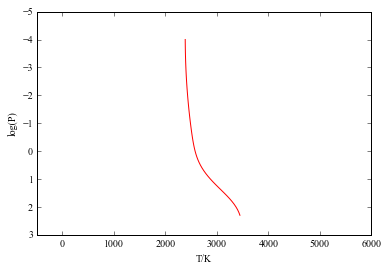

In [25]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([-500., 6000.,3.0,-5.0])
logP = np.log10(press)
plotT = TPmod.set_prof(proftype,coarsePress,press,theta[18:])
plt.plot(plotT,logP, "r-")

plt.ylabel(r'log(P)')
plt.xlabel('T/K')


In [26]:
LP = testkit.lnprob(theta,*runargs) #* -2. / (obspec.shape[1] /3.)
#print testkit.lnprob(theta2,*runargs) * -2. / (obspec.shape[1] /3.)
print LP

a1 =  0.69
a2 =  0.14
P1 =  0.042
P3 =  1.9
T3 =  3500.0
T =  [ 2385.52867187  2386.03147831  2386.66323602  2387.44085655  2388.37996374
  2389.49443131  2390.79610055  2392.29468562  2393.99784626  2395.91138765
  2398.03953866  2400.38526017  2402.95054478  2405.73668136  2408.7444712
  2411.97439313  2415.42672215  2419.10161007  2422.99913741  2427.11934527
  2431.46225377  2436.02775599  2440.81574278  2445.8261047   2451.05866582
  2456.51317681  2462.18935357  2468.08702817  2474.20653012  2480.54948292
  2487.12027396  2493.92851405  2500.99281204  2508.34611129  2516.04263447
  2524.16615435  2532.83888423  2542.22984882  2552.56127858  2564.11150072
  2577.21030813  2592.23381356  2609.5891629   2629.69508851  2652.95833446
  2679.74733014  2710.3643192   2745.01678555  2783.78875788  2826.6127474
  2873.24388221  2923.2391816   2975.94646471  3030.50842962  3085.88720917
  3140.91266955  3194.35384632  3245.00788224  3291.79591972  3333.85213944
  3370.59177784  3401.746969

In [14]:
#len(pickle.dumps([theta,runargs], -1)) / 1e9

In [ ]:
#for gas in range (0,ngas):
##    test= pickle.load( open(lists[gas], "rb" ) )[3]
#    test[np.isnan(test)] = 1.0
#    print test[np.where(np.less(test,0))]
print cloudprof.shape

In [ ]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([-8., 2.,3.0,-5.0])
logP = np.log10(press)
plt.plot(np.log10(cloudprof[0,:,0]),logP, "r-")

plt.ylabel(r'log(P)')
plt.xlabel('log10(dtau)')

In [ ]:
import forwardmodel
print forwardmodel.marv.__doc__